In [65]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import EarlyStopping


In [76]:
df = pd.read_csv("data.csv")
df.columns = df.columns.str.strip()
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
for col in df.columns:
    df[col] = df[col].replace({'\$': '', ',': ''}, regex=True).astype(float)
df.head()

,Close/Last,Volume,Open,High,Low
Date,,,,,
2020-02-28,273.36,106721200.0,257.26,278.41,256.37
2020-02-27,273.52,80151380.0,281.10,286.00,272.96
2020-02-26,292.65,49678430.0,286.53,297.88,286.50
2020-02-25,288.08,57668360.0,300.95,302.53,286.13
2020-02-24,298.18,55548830.0,297.26,304.18,289.23


In [90]:
X = df.drop(columns='Close/Last', axis=1)
Y = df['Close/Last'].values.reshape(-1, 1)
# Standardize data
scaler = StandardScaler()
standardized_data = scaler.fit_transform(X)
X = standardized_data
# Scale the target variable
#standardized_data = scaler.fit_transform(Y)
#Y = standardized_data

In [102]:
train_size = int(len(Y) * 0.8)  # 80% for training
X_train = X[:train_size]
Y_train = Y[:train_size]
X_test = X[train_size:]
Y_test = Y[train_size:]

In [103]:
# Create sequences for LSTM
def create_dataset(data_X, data_Y, time_step=1):
    Xs, ys = [], []
    for i in range(len(data_X) - time_step - 1):
        Xs.append(data_X[i:(i + time_step)])
        ys.append(data_Y[i + time_step])
    return np.array(Xs), np.array(ys)

In [104]:
time_step = 10
X_train_seq, Y_train_seq = create_dataset(X_train, Y_train, time_step)
X_test_seq, Y_test_seq = create_dataset(X_test, Y_test, time_step)

# Reshape input to be [samples, time steps, features]
X_train_seq = X_train_seq.reshape(X_train_seq.shape[0], X_train_seq.shape[1], X_train_seq.shape[2])
X_test_seq = X_test_seq.reshape(X_test_seq.shape[0], X_test_seq.shape[1], X_test_seq.shape[2])

In [109]:
# LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]), activation='relu'))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=True, activation='relu'))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=False, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


<bound method Model.summary of <Sequential name=sequential_2, built=True>>

In [110]:
model.fit(X_train_seq, Y_train_seq, epochs=200, batch_size=32, verbose=1, shuffle=False)

Epoch 1/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - loss: 34959.9297
Epoch 2/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 4680358.5000
Epoch 3/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 18570.4629
Epoch 4/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 1505388.0000
Epoch 5/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 15603.9551
Epoch 6/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 14903.0312
Epoch 7/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 14550.9717
Epoch 8/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 14430.7676
Epoch 9/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 10573.9990
Epoch 10/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 1635795.7500
Epoch 11/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 25256.8086
Epoch 12/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 8546.4707
Epoch 13/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 4326.7437
Epoch 14/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 3718.656

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step


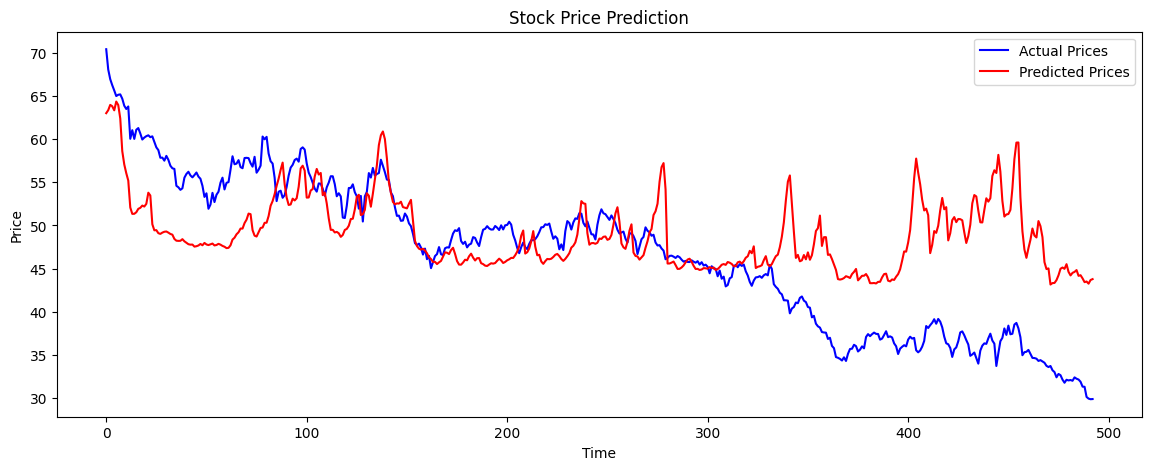

In [111]:
# Make predictions
predictions = model.predict(X_test_seq)

# Prepare the actual values for plotting
Y_test_actual = Y[train_size + time_step + 1:]

# Plot the results
plt.figure(figsize=(14, 5))
plt.plot(Y_test_actual, label='Actual Prices', color='blue')
plt.plot(predictions, label='Predicted Prices', color='red')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()